In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [33]:
import pandas as pd
import nltk
#nltk.download()
from nltk.corpus import stopwords
import re
import string
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
import matplotlib.pyplot as plt

In [4]:
# Import Data
vdata = pd.read_csv('drive/MyDrive/Dataset/Videos_data.csv')
vdata.head(10)

,Unnamed: 0,Video Id,Title,Description,Category
0,0,ehmsJLZlCZ0,Ep 1| Travelling through North East India | Of...,"The journey to Arunachal, North East India beg...",travel
1,1,e2NQE41J5eM,How do I travel so much ! How do I earn money!!,SUBSCRIBE - https://goo.gl/dEtSMJ ('MountainTr...,travel
2,2,i9E_Blai8vk,TRAVEL VLOG ∙ Welcome to Bali | PRISCILLA LEE,I had the chance to fly out to Bali with my wh...,travel
3,3,#NAME?,GOA TRAVEL DIARY | FOUR DAYS IN GOA | TRAVEL O...,Hope you enjoy MY GOA TRAVEL DIARY this video!...,travel
4,4,7ByoBJYXU0k,5 Steps to Becoming a Travel Blogger,"Travel blogger, Nikki Vargas, of The Pin the M...",travel
5,5,yvn79Rv0F48,Backpacking In Meghalaya | NorthEast India Tri...,"In this video I explored North East India, sta...",travel
6,6,SL_YBLWdZb8,Welcome to Peru! | Best Essential Tips &amp; T...,Welcome to Peru! This essential travel guide w...,travel
7,7,kiNyRY5s7n8,How to Start a Travel Blog [2019] Travel Blogg...,Create a Travel Blog Website for Just $3.95 + ...,travel
8,8,kY41XgTEEQU,A Day with KSRTC Bus Fans - Aanavandi Travel B...,ആനവണ്ടി ഭ്രാന്തൻമാരോടൊപ്പം കുമളിയിൽ ഒരു ദിവസം ...,travel
9,9,7mIzRYh8jGA,What is it like to travel in PAKISTAN?,Subscribe now: https://goo.gl/6zXZGK Watch the...,travel


In [5]:
data = vdata.drop(['Unnamed: 0'], axis = 1)

data.isnull().sum()

Video Id         0
Title            0
Description    334
Category         0
dtype: int64

In [6]:
print(data.shape)
data = data.dropna(how='any')
print(data.shape)

(10333, 4)
(9999, 4)


In [10]:
# nltk.download('stopwords')
# nltk.download('wordnet')

In [11]:
stop_words = set(stopwords.words('english'))
##Creating a list of custom stopwords
new_words = ["fig","figure","image","sample","using", 
             "show", "result", "large", 
             "also", "one", "two", "three", 
             "four", "five", "seven","eight","nine"]
stop_words = list(stop_words.union(new_words))

In [15]:
def pre_process(text):
    
    # lowercase
    text=text.lower()
    
    #remove tags
    text=re.sub("&lt;/?.*?&gt;"," &lt;&gt; ",text)
    
    # remove special characters and digits
    text=re.sub("(\\d|\\W)+"," ",text)
    
    ##Convert to list from string
    text = text.split()
    
    # remove stopwords
    text = [word for word in text if word not in stop_words]

    # remove words less than three letters
    text = [word for word in text if len(word) >= 3]

    # lemmatize
    lmtzr = WordNetLemmatizer()
    text = [lmtzr.lemmatize(word, "v") for word in text]
    
    return ' '.join(text)

In [19]:
# The frac keyword argument specifies the fraction of rows to return in the random sample
# specifying drop=True prevents .reset_index from creating a column containing the old index entries.
data = data.sample(frac=1).reset_index(drop=True)
docs = pd.DataFrame()
docs['Title'] = data['Title'].iloc[:5000].apply(lambda x:pre_process(x))
docs['Description'] = data['Description'].iloc[:5000].apply(lambda x:pre_process(x))

In [20]:
docs.head()

,Title,Description
0,gringos eat mexican snack esquites chip churros,kinetickennons gmail com media inquiries press...
1,toyota production documentary toyota manufactu...,toyota production system documentary toyota ma...
2,lightning home cook competition mac amp cheese,see lightning player cook like pro natural gas...
3,must know paint hack beginners,number must know paint hack beginners fire pai...
4,robotics beginners arduino detail explanation,get discount wireless car robotics arduino rob...


In [21]:
# Label encoding the classes

docs['classes'] = data['Category']
docs['classes'].value_counts()

manufacturing             866
science and technology    849
art and music             845
travel                    816
history                   814
food                      810
Name: classes, dtype: int64

In [24]:
# Encode classes
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
le.fit(docs['classes'])
docs['classes'] = le.transform(docs['classes'])
docs.head()

,Title,Description,classes
0,gringos eat mexican snack esquites chip churros,kinetickennons gmail com media inquiries press...,1
1,toyota production documentary toyota manufactu...,toyota production system documentary toyota ma...,3
2,lightning home cook competition mac amp cheese,see lightning player cook like pro natural gas...,1
3,must know paint hack beginners,number must know paint hack beginners fire pai...,0
4,robotics beginners arduino detail explanation,get discount wireless car robotics arduino rob...,4


In [46]:
le.classes_
# art and music -> 0, food -> 1, and so on.

array(['art and music', 'food', 'history', 'manufacturing',
       'science and technology', 'travel'], dtype=object)

In [26]:
docs['classes'].value_counts()

3    866
4    849
0    845
5    816
2    814
1    810
Name: classes, dtype: int64

In [25]:
# Vectorizing text features using TF-IDF

from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_title = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='latin-1', ngram_range=(1, 2), stop_words='english')
tfidf_desc = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='latin-1', ngram_range=(1, 2), stop_words='english')
labels = docs['classes']
features_title = tfidf_title.fit_transform(docs['Title']).toarray()
features_description = tfidf_desc.fit_transform(docs['Description']).toarray()
print('Title Features Shape: ' + str(features_title.shape))
print('Description Features Shape: ' + str(features_description.shape))

Title Features Shape: (5000, 1267)
Description Features Shape: (5000, 2690)


In [29]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from keras.utils.np_utils import to_categorical
from sklearn.model_selection import train_test_split

# The maximum number of words to be used. (most frequent)
MAX_NB_WORDS = 10000
# Max number of words in each complaint.
MAX_SEQUENCE_LENGTH = 50
# This is fixed.
EMBEDDING_DIM = 100

# Combining titles and descriptions into a single sentence
titles = docs['Title'].values
descriptions = docs['Description'].values
data_for_lstms = []
for i in range(len(titles)):
    temp_list = [titles[i], descriptions[i]]
    data_for_lstms.append(' '.join(temp_list))

tokenizer = Tokenizer(num_words=MAX_NB_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(data_for_lstms)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

# Convert the data to padded sequences
X = tokenizer.texts_to_sequences(data_for_lstms)
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', X.shape)

# One-hot Encode labels
Y = pd.get_dummies(docs['classes']).values
print('Shape of label tensor:', Y.shape)

# Splitting into training and test set
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, random_state = 42)

Found 16060 unique tokens.
Shape of data tensor: (5000, 50)
Shape of label tensor: (5000, 6)


In [41]:
titles[0:4]

array(['gringos eat mexican snack esquites chip churros',
       'toyota production documentary toyota manufacture production assembly toyota factory',
       'lightning home cook competition mac amp cheese',
       'must know paint hack beginners'], dtype=object)

In [42]:
data_for_lstms[0:4]

['gringos eat mexican snack esquites chip churros kinetickennons gmail com media inquiries press mention product review tour review say hey subscribe channel',
 'toyota production documentary toyota manufacture production assembly toyota factory toyota production system documentary toyota manufacture production assembly toyota factory subscribe https goo new car',
 'lightning home cook competition mac amp cheese see lightning player cook like pro natural gas cook like pro save energy earn rebate',
 'must know paint hack beginners number must know paint hack beginners fire paint colorful candy puffy shave foam ideas cut short gonna find tons']

In [30]:
# Define LSTM Model
model = Sequential()
model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X.shape[1]))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(6, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 50, 100)           1000000   
                                                                 
 spatial_dropout1d (SpatialD  (None, 50, 100)          0         
 ropout1D)                                                       
                                                                 
 lstm (LSTM)                 (None, 100)               80400     
                                                                 
 dense (Dense)               (None, 6)                 606       
                                                                 
Total params: 1,081,006
Trainable params: 1,081,006
Non-trainable params: 0
_________________________________________________________________
None


In [32]:
# Training LSTM Model
epochs = 10
batch_size = 128

history = model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size,validation_split=0.2)

Epoch 1/10
24/24 [==============================] - 5s 210ms/step - loss: 0.0334 - accuracy: 0.9950 - val_loss: 0.1816 - val_accuracy: 0.9573
Epoch 2/10
24/24 [==============================] - 7s 305ms/step - loss: 0.0334 - accuracy: 0.9963 - val_loss: 0.1668 - val_accuracy: 0.9600
Epoch 3/10
24/24 [==============================] - 6s 268ms/step - loss: 0.0246 - accuracy: 0.9967 - val_loss: 0.1733 - val_accuracy: 0.9613
Epoch 4/10
24/24 [==============================] - 5s 202ms/step - loss: 0.0146 - accuracy: 0.9983 - val_loss: 0.1671 - val_accuracy: 0.9653
Epoch 5/10
24/24 [==============================] - 5s 203ms/step - loss: 0.0123 - accuracy: 0.9987 - val_loss: 0.1809 - val_accuracy: 0.9587
Epoch 6/10
24/24 [==============================] - 5s 201ms/step - loss: 0.0135 - accuracy: 0.9977 - val_loss: 0.1926 - val_accuracy: 0.9520
Epoch 7/10
24/24 [==============================] - 5s 202ms/step - loss: 0.0135 - accuracy: 0.9980 - val_loss: 0.1730 - val_accuracy: 0.9613
Epoch 

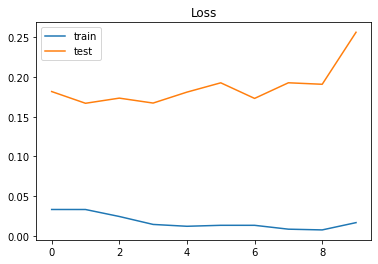

In [34]:
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

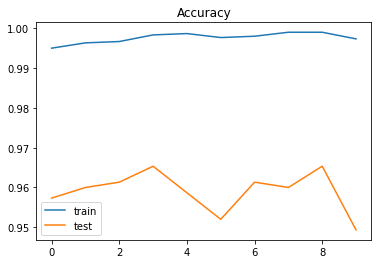

In [37]:
plt.title('Accuracy')
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.legend()
plt.show()

In [38]:
# Saving the tokenizer and the model:

import pickle

pickle.dump(tokenizer, open('drive/MyDrive/Dataset/DataScience-Pianalytix-Models/video_classification-tokenizer.pkl', 'wb'))
model.save('drive/MyDrive/Dataset/DataScience-Pianalytix-Models/video_classification-model.h5')